In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os, copy
from PIL import Image
from IPython import display

In [10]:
def init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight)

class NN(nn.Module):
    
    def __init__(self, activation=nn.Tanh, input_size=2, num_neurons=2, num_layers=9, output_size=3):
        super(NN, self).__init__()
        layers = [nn.Linear(input_size, num_neurons, bias=True), activation()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons, bias=False), activation()]
        layers += [nn.Linear(num_neurons, output_size, bias=False), nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

def loss(output):
    #img = im * 0.5 + 0.5
    #saturation = (img.max(1)[0] - img.min(1)[0]) / (img.max(1)[0] + self.eps)
    #saturation[img.max(1)[0] == 0] = 0
    loss = torch.mean(output)
    return loss

In [11]:
def plot_image(colors, fig_size=6):
    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(colors, interpolation='nearest', vmin=0, vmax=1)


def generate(size_x, size_y, pattern='', scale=0.1, offset=1.5, width=0, output_size=3, **kwargs):
    net = NN(output_size=output_size, **kwargs)
    net.apply(init)
    if pattern == 'circular':
        input = generate_circular_input(size_x, size_y, scale)
    elif pattern == 'square':
        input = generate_square_input(size_x, size_y, offset)
    elif pattern == 'sin':
        input = generate_sin_input(size_x, size_y, width)
    else:
        input = generate_input(size_x, size_y)
    colors = run_net(net, input, size_x, size_y, output_size)
    plot_image(colors)

    name = f'{pattern}_{scale}_{offset}_{width}_{output_size}'

    return net, colors, input, name


def save(colors, name):
    plt.imsave(f"images/{name}.png", colors)


def run_net(net, input, size_x, size_y, output_size=3):
    img = net(torch.tensor(input).type(torch.FloatTensor)).detach().numpy()
    return img.reshape(size_x, size_y, output_size)


def train_net(size_x, size_y, **kwargs):
    net = NN(**kwargs)
    net.apply(init)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    
    for i in range(10):
        input = generate_input(size_x, size_y)
        img = net(torch.tensor(input).type(torch.FloatTensor))
        loss = torch.mean(img)    
    
        img = img.detach().numpy()
        colors = img.reshape(size_x, size_y, 3)
        plot_image(colors, 4)

        loss.backward()
        optimizer.step()

    return 0


def gen_save(size_x, size_y, name, **kwargs):
    _, c, _ = generate(size_x, size_y, **kwargs)
    save(c, name)

In [12]:
def generate_input(size_x=128, size_y=128):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 2))
    for i in x:
        for j in y:
            colors[i][j] = np.array([float(i) / size_y - 1.5, float(j) / size_x + 1.5])
            #colors[i][j] = np.array([np.sin(i/(size_x/5)), np.cos(j/(size_y/5))])
            #colors[i][j] = np.array(np.sin(i), np.cos(j))
            #colors[i][j] = np.random.normal(float(i) / size_y, float(j) / size_x, size=(1, 2))
    return colors.reshape(size_x * size_y, 2)


def generate_sin_input(size_x=128, size_y=128, width=1):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 2))
    for i in x:
        for j in y:
            colors[i][j] = np.array([np.sin(i * width) * size_x , j])
    return colors.reshape(size_x * size_y, 2)    


def generate_circular_input(size_x=128, size_y=128, scale=0.1):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 3))
    for i in x:
        for j in y:
                colors[i][j] = np.array([
                    float(i) / size_y - scale,
                    float(j) / size_y - scale,
                    np.sqrt(((i*scale-(size_x*scale/2))**2) + ((j*scale-(size_y*scale/2))**2))])

    return colors.reshape(size_x * size_y, 3)

def generate_square_input(size_x=128, size_y=128, offset=1.5):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 2))
    for i in x:
        for j in y:
                colors[i][j] = np.array([abs(max([i,j])/size_x - offset),
                                         abs(max([i,j])/size_y - offset)])
    return colors.reshape(size_x * size_y, 2)


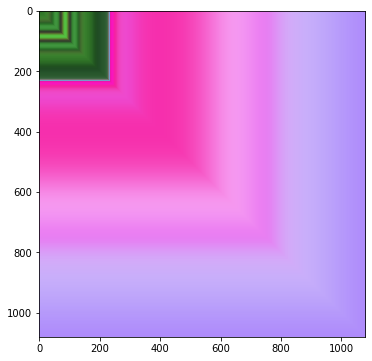

In [14]:
_, c, _, name = generate(1080, 1080, pattern='square', output_size=4, offset=0.08, num_layers=8, num_neurons=16)

In [ ]:
save(c, 'square_rgba_l8_n16')

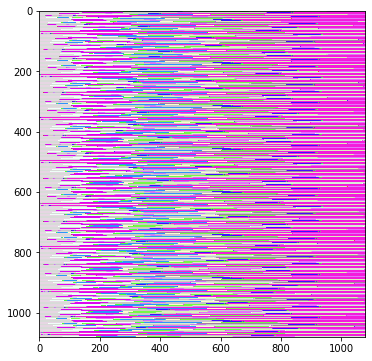

In [15]:
_, c, _, name = generate(1080, 1080, pattern='sin', output_size=4, num_layers=8, num_neurons=16, width=100)

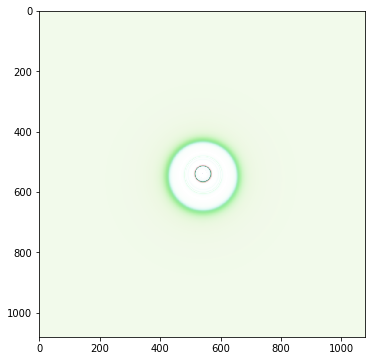

In [16]:
_, c, _, name = generate(1080, 1080, pattern='circular', input_size=3, output_size=4, num_layers=8, num_neurons=16)

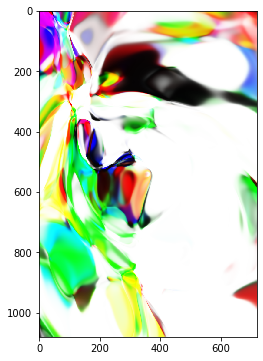

In [17]:
_, c, _, name = generate(1080, 720, pattern='circular', input_size=3, output_size=4, num_layers=7, num_neurons=32, scale=0.001)

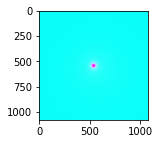

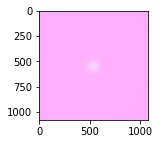

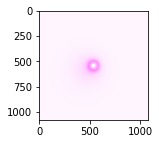

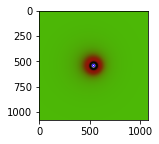

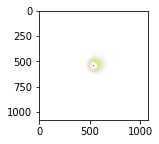

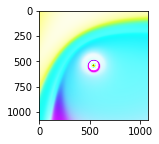

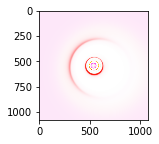

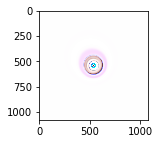

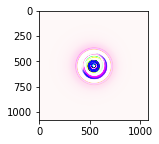

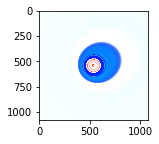

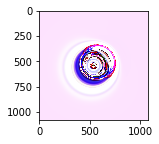

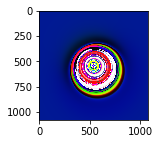

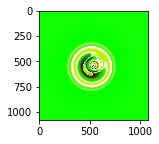

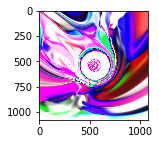

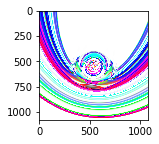

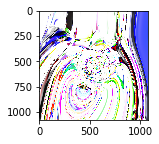

In [18]:
size_x = 1080
size_y = 1080
input = generate_circular_input(size_x, size_y)
for i in range(0, 16):
  net = NN(num_layers=i, num_neurons=32, input_size=3, output_size=4)
  net.apply(init)
  colors = run_net(net, input, size_x, size_y, output_size=4)
  plot_image(colors, fig_size=2)